# Tests de TextTokenizarion puis d'Embedding

In [428]:
import time
import pathlib
import gzip

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers

from sklearn.model_selection import train_test_split

random_seed = 0
np.random.seed(random_seed)

# set random seed for keras reproductibility
try:
    keras.utils.set_random_seed(random_seed)
except Exception:
    tf.random.set_seed(random_seed)

In [431]:
import FreeMobileSMS as sms

In [2]:
data_work = pd.read_csv(
    pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp_1563108.csv'), 
    usecols=['target', 'lemmas_not_filtered'],
    encoding='ISO-8859-1',
    #nrows=100000,
)
data_work.rename(columns={'lemmas_not_filtered':'text'}, inplace=True)
display(data_work.head(), data_work.shape)
data_work = data_work.groupby('target', group_keys=False).apply(lambda x: x.sample(50000, random_state=random_seed))
display(data_work.head(), data_work.shape)

,target,text
0,0,"$ url$ - awww , that be a bummer . you shoulda..."
1,0,be upset that he can not update his facebook b...
2,0,I dive many time for the ball . manage to save...
3,0,my whole body feel itchy and like its on fire
4,0,"no , it be not behave at all . I be mad . why ..."


(1452791, 2)

,target,text
469259,0,I do not have a background for my twitter stre...
152271,0,I do many thing but miss tweet
597612,0,most probably - eww all that pasty white skin ...
708306,0,"ohh , how bad I sleep"
59100,0,"hell yeah u be texte I I remember , I be at my..."


(100000, 2)

In [3]:
data_work.target.value_counts(dropna=False)

0    50000
1    50000
Name: target, dtype: int64

In [4]:
def architecture001(f_opti, f_loss, f_metrics, max_tokens=20000, hidden_dim=16):
        
    inputs = keras.Input(shape=(max_tokens,), dtype="int64")
    
    x = layers.Dense(hidden_dim, activation='relu')(inputs)
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model

In [45]:
def architecture002_oh(f_opti, f_loss, f_metrics):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = tf.one_hot(inputs, depth=text_vectorizationB0.vocabulary_size())
    x = layers.Bidirectional(layers.LSTM(32))(x) # 64
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model

In [31]:
def architecture002(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(x) # 64
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model

In [32]:
def architecture003(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    x = layers.Dense(24, activation='relu')(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model

In [5]:
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau

def init_callbacks2(model_name):

    # Define savepoints
    filepath = pathlib.Path("models", f"{model_name}.keras")

    checkpoint = ModelCheckpoint(
        monitor="val_accuracy",
        mode="max",
        filepath=filepath,
        save_best_only=True,
        verbose=1,
    )

    # Define EarlyStopping conditions
    es = EarlyStopping(
        monitor='val_loss', # 'binary_accuracy'
        mode='min', # 'max'
        patience=5,
        min_delta=0.01, 
        restore_best_weights=True, 
        verbose=1,
    )
    
    return [checkpoint, es]

In [302]:
from gensim.models import KeyedVectors
import gensim.downloader as api

def load_gensim_embedding(embedding_name, binary=False):
    
    embedding_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'embedding_models', f'{embedding_name}.gz')
    try:
        if embedding_path.is_file():
            print(f"Loading from {embedding_path}")
            embedding_model = KeyedVectors.load_word2vec_format(embedding_path, binary=binary)
        else:
            print("Loading from the Git repos with API")
            embedding_model = api.load(embedding_name)
            
        return embedding_model
    except Exception as e:
        print(f"The provided embedding model couldn't be loaded correctly: {e}")
        
def load_trained_glove(embedding_name):
    
    def parse_file(file):
        embeddings_index = {}
        for line in file:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs
        return embeddings_index

    try:
        embedding_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'embedding_models', f'{embedding_name}.gz')
        if embedding_path.is_file():
            print(f"Loading from gZip: {embedding_path}")
            with gzip.open(embedding_path, mode='rt') as f:
                return parse_file(f)
        
        embedding_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'embedding_models', f'{embedding_name}.txt')
        if embedding_path.is_file():
            print(f"Loading from TXT: {embedding_path}")
            with open(embedding_path) as f:
                return parse_file(f)
        else:
            raise FileNotFoundError(f"No such model found (it must be {embedding_name}.txt or {embedding_name}.gz)")
            
    except Exception as e:
        print(f"The provided embedding model couldn't be loaded correctly: {e}")

In [310]:
def convert_embedding_matrix(vocabulary, embeddings_index, max_tokens, embedding_dim=100):
    
    hits = 0
    misses = 0
    misses_list = []
    
    word_index = dict(zip(vocabulary, range(len(vocabulary))))
    
    embedding_matrix = np.zeros((max_tokens, embedding_dim))
    
    for word, i in word_index.items():
        if i < max_tokens:
            try:
                embedding_vector = embeddings_index.get_vector(word)
            except AttributeError:
                embedding_vector = embeddings_index.get(word)
            except KeyError:
                embedding_vector = None
        if embedding_vector is not None:
            hits += 1
            embedding_matrix[i] = embedding_vector
        else:
            misses += 1
            misses_list.append(word)
            
    print(f"Converted {hits} words, and couldn't find {misses} words")
    print(f"Missing words: {misses_list}")
            
    return embedding_matrix

In [ ]:
batch_size=256

### Divisons le jeu de données en `Train` et `Test` sets

In [95]:
X_train, X_test, y_train, y_test = train_test_split(data_work['text'], data_work['target'], test_size=0.2, random_state=random_seed, stratify=data_work['target'])

In [ ]:
sms.send("Starting Bag of words models", stop=False)

## Bags of words / Bag of N-gram models

### Test A0 - NN | Ngram=2 | int

#### Standardize & Tokenize

In [10]:
text_vectorization0 = tf.keras.layers.TextVectorization(
    output_mode='int', # int, multi_hot, count, tf_idf
    max_tokens=20000,
    ngrams=2,
    output_sequence_length=79 # search the max size by default
)

In [11]:
text_vectorization0.adapt(data_work.text)

In [12]:
print(text_vectorization0.get_vocabulary()[:20], "...")

['', '[UNK]', 'i', 'be', 'to', 'the', 'a', 'not', 'my', 'and', 'it', 'you', 'have', 'do', 'for', 'in', 'i be', 'go', 'of', 'that'] ...


#### Prepare dataset

In [13]:
X_train_ready = text_vectorization0(X_train)
X_test_ready = text_vectorization0(X_test)

In [14]:
X_train[:2]

206231                                       now I m bore
1405057    watch juno ... again . its a really good movie
Name: text, dtype: object

In [15]:
X_train_ready[:2]

<tf.Tensor: shape=(2, 79), dtype=int64, numpy=
array([[   34,     2,    71,  1072,   231,    72, 14736,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [   83,     1,   134,    84,     6,    75,    30,   211,     1,
            1,     1,  1261,  1657,  2004,  3967,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0, 

#### Train model

In [16]:
model = architecture001("adam", "binary_crossentropy", ['accuracy'], X_train_ready[:0].shape[1])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 79)]              0         
                                                                 
 dense (Dense)               (None, 16)                1280      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 predictions (Dense)         (None, 1)                 17        
                                                                 
Total params: 1,297
Trainable params: 1,297
Non-trainable params: 0
_________________________________________________________________


In [20]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks2(f"MINI_TESTS_A00"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/50
311/313 [============================>.] - ETA: 0s - loss: 402.9994 - accuracy: 0.5019
Epoch 1: val_accuracy improved from -inf to 0.50215, saving model to models/MINI_TESTS_00.keras
313/313 [==============================] - 1s 3ms/step - loss: 401.2412 - accuracy: 0.5021 - val_loss: 31.0522 - val_accuracy: 0.5021
Epoch 2/50
311/313 [============================>.] - ETA: 0s - loss: 12.1510 - accuracy: 0.5025
Epoch 2: val_accuracy did not improve from 0.50215
313/313 [==============================] - 1s 2ms/step - loss: 12.0973 - accuracy: 0.5027 - val_loss: 3.2959 - val_accuracy: 0.4990
Epoch 3/50
299/313 [===========================>..] - ETA: 0s - loss: 2.2541 - accuracy: 0.5031
Epoch 3: val_accuracy did not improve from 0.50215
313/313 [==============================] - 1s 2ms/step - loss: 2.2152 - accuracy: 0.5026 - val_loss: 1.4084 - val_accuracy: 0.5004
Epoch 4/50
305/313 [============================>.] - ETA: 0s - loss: 1.1983 - accuracy: 0.5021
Epoch 4: val_accur

In [21]:
model = keras.models.load_model("models/MINI_TESTS_A00.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorization0(raw_txt)
model.predict(raw_txt)

In [ ]:
t0 = time.perf_counter()
raw_txt = tf.convert_to_tensor(X_test)
raw_txt = text_vectorization0(raw_txt)
y_preds_proba = model.predict(raw_txt)
y_preds = np.where(y_preds_proba > 0.5, 1,0)
inf_time = time.perf_counter() - t0

In [ ]:
model_name = "Test A00"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

#### Compare

In [ ]:
from classification_utils import scores_df
scores_df

In [ ]:
sms.send("TestA00 Done", stop=False)

### Test A1 - NN | Ngram=1 | multi_hot

#### Standardize & Tokenize

In [23]:
text_vectorization1 = tf.keras.layers.TextVectorization(
    output_mode='multi_hot', # int, multi_hot, count, tf_idf
    max_tokens=20000,
    ngrams=1,
    # output_sequence_length=60 # search the max size by default
)

In [24]:
text_vectorization1.adapt(data_work.text)

In [25]:
print(text_vectorization1.get_vocabulary()[:20], "...")

['[UNK]', 'i', 'be', 'to', 'the', 'a', 'not', 'my', 'and', 'it', 'you', 'have', 'do', 'for', 'in', 'go', 'of', 'that', 'get', 'on'] ...


#### Prepare dataset

In [26]:
X_train_ready = text_vectorization1(X_train)
X_test_ready = text_vectorization1(X_test)

2022-08-04 18:27:05.773784: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6400000000 exceeds 10% of free system memory.
2022-08-04 18:27:06.491803: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1600000000 exceeds 10% of free system memory.


In [27]:
X_train[:2]

206231                                       now I m bore
1405057    watch juno ... again . its a really good movie
Name: text, dtype: object

In [28]:
X_train_ready[:2]

<tf.Tensor: shape=(2, 20000), dtype=float32, numpy=
array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

#### Train model

In [29]:
model = architecture001("adam", "binary_crossentropy", ['accuracy'], X_train_ready[:0].shape[1])

In [30]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_1 (Dense)             (None, 16)                320016    
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 predictions (Dense)         (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________


In [32]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks2(f"MINI_TESTS_A01"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/50
311/313 [============================>.] - ETA: 0s - loss: 0.5754 - accuracy: 0.7238
Epoch 1: val_accuracy improved from -inf to 0.77200, saving model to models/MINI_TESTS_01.keras
313/313 [==============================] - 9s 27ms/step - loss: 0.5752 - accuracy: 0.7239 - val_loss: 0.5018 - val_accuracy: 0.7720
Epoch 2/50
312/313 [============================>.] - ETA: 0s - loss: 0.4838 - accuracy: 0.7828
Epoch 2: val_accuracy improved from 0.77200 to 0.77960, saving model to models/MINI_TESTS_01.keras
313/313 [==============================] - 8s 27ms/step - loss: 0.4839 - accuracy: 0.7828 - val_loss: 0.4750 - val_accuracy: 0.7796
Epoch 3/50
311/313 [============================>.] - ETA: 0s - loss: 0.4505 - accuracy: 0.8004
Epoch 3: val_accuracy improved from 0.77960 to 0.78265, saving model to models/MINI_TESTS_01.keras
313/313 [==============================] - 8s 27ms/step - loss: 0.4505 - accuracy: 0.8003 - val_loss: 0.4675 - val_accuracy: 0.7826
Epoch 4/50
313/313 [==

#### Evaluate

In [33]:
model = keras.models.load_model("models/MINI_TESTS_A01.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorization1(raw_txt)
model.predict(raw_txt)

In [ ]:
t0 = time.perf_counter()
raw_txt = tf.convert_to_tensor(X_test)
raw_txt = text_vectorization1(raw_txt)
y_preds_proba = model.predict(raw_txt)
y_preds = np.where(y_preds_proba > 0.5, 1,0)
inf_time = time.perf_counter() - t0

In [ ]:
model_name = "Test A01"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

#### Compare

In [ ]:
from classification_utils import scores_df
scores_df

In [ ]:
sms.send("TestA01 Done", stop=False)

### Test A2 - NN | Ngram=2 | multi_hot

#### Standardize & Tokenize

In [35]:
text_vectorization2 = tf.keras.layers.TextVectorization(
    output_mode='multi_hot', # int, multi_hot, count, tf_idf
    max_tokens=20000,
    ngrams=2,
    # output_sequence_length=60 # search the max size by default
)

In [36]:
text_vectorization2.adapt(data_work.text)

In [37]:
print(text_vectorization2.get_vocabulary()[:20], "...")

['[UNK]', 'i', 'be', 'to', 'the', 'a', 'not', 'my', 'and', 'it', 'you', 'have', 'do', 'for', 'in', 'i be', 'go', 'of', 'that', 'get'] ...


#### Prepare dataset

In [38]:
X_train_ready = text_vectorization2(X_train)
X_test_ready = text_vectorization2(X_test)

2022-08-04 18:28:28.220769: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6400000000 exceeds 10% of free system memory.
2022-08-04 18:29:20.499922: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1600000000 exceeds 10% of free system memory.


In [39]:
X_train[:2]

206231                                       now I m bore
1405057    watch juno ... again . its a really good movie
Name: text, dtype: object

In [40]:
X_train_ready[:2]

<tf.Tensor: shape=(2, 20000), dtype=float32, numpy=
array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

#### Train model

In [41]:
model = architecture001("adam", "binary_crossentropy", ['accuracy'], X_train_ready[:0].shape[1])

In [42]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_2 (Dense)             (None, 16)                320016    
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 predictions (Dense)         (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________


In [44]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks2(f"MINI_TESTS_A02"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/50
311/313 [============================>.] - ETA: 0s - loss: 0.5554 - accuracy: 0.7388
Epoch 1: val_accuracy improved from -inf to 0.78690, saving model to models/MINI_TESTS_02.keras
313/313 [==============================] - 13s 32ms/step - loss: 0.5551 - accuracy: 0.7390 - val_loss: 0.4797 - val_accuracy: 0.7869
Epoch 2/50
313/313 [==============================] - ETA: 0s - loss: 0.4511 - accuracy: 0.8037
Epoch 2: val_accuracy improved from 0.78690 to 0.79545, saving model to models/MINI_TESTS_02.keras
313/313 [==============================] - 11s 35ms/step - loss: 0.4511 - accuracy: 0.8037 - val_loss: 0.4546 - val_accuracy: 0.7954
Epoch 3/50
312/313 [============================>.] - ETA: 0s - loss: 0.4080 - accuracy: 0.8263
Epoch 3: val_accuracy did not improve from 0.79545
313/313 [==============================] - 10s 32ms/step - loss: 0.4080 - accuracy: 0.8263 - val_loss: 0.4501 - val_accuracy: 0.7952
Epoch 4/50
311/313 [============================>.] - ETA: 0s - los

#### Evaluate

In [45]:
model = keras.models.load_model("models/MINI_TESTS_A02.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorization2(raw_txt)
model.predict(raw_txt)

In [ ]:
t0 = time.perf_counter()
raw_txt = tf.convert_to_tensor(X_test)
raw_txt = text_vectorization2(raw_txt)
y_preds_proba = model.predict(raw_txt)
y_preds = np.where(y_preds_proba > 0.5, 1,0)
inf_time = time.perf_counter() - t0

In [ ]:
model_name = "Test A02"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

#### Compare

In [ ]:
from classification_utils import scores_df
scores_df

In [ ]:
sms.send("TestA02 Done", stop=False)

### Test A3 - NN | Ngram=2 | count

#### Standardize & Tokenize

In [7]:
text_vectorization3 = tf.keras.layers.TextVectorization(
    output_mode='count', # int, multi_hot, count, tf_idf
    max_tokens=20000,
    ngrams=2,
    # output_sequence_length=60 # search the max size by default
)

2022-08-04 18:32:26.281428: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-04 18:32:26.281468: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-04 18:32:26.281493: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (valkea-XPS): /proc/driver/nvidia/version does not exist
2022-08-04 18:32:26.282044: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
text_vectorization3.adapt(data_work.text)

In [9]:
print(text_vectorization3.get_vocabulary()[:20], "...")

['[UNK]', 'i', 'be', 'to', 'the', 'a', 'not', 'my', 'and', 'it', 'you', 'have', 'do', 'for', 'in', 'i be', 'go', 'of', 'that', 'get'] ...


#### Prepare dataset

In [10]:
X_train_ready = text_vectorization3(X_train)
X_test_ready = text_vectorization3(X_test)

2022-08-04 18:32:33.482820: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6400000000 exceeds 10% of free system memory.
2022-08-04 18:32:34.235963: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1600000000 exceeds 10% of free system memory.


In [11]:
X_train[:2]

206231                                       now I m bore
1405057    watch juno ... again . its a really good movie
Name: text, dtype: object

In [12]:
X_train_ready[:2]

<tf.Tensor: shape=(2, 20000), dtype=float32, numpy=
array([[0., 1., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

#### Train model

In [13]:
model = architecture001("adam", "binary_crossentropy", ['accuracy'], X_train_ready[:0].shape[1])

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense (Dense)               (None, 16)                320016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 predictions (Dense)         (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________


In [16]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks2(f"MINI_TESTS_A03"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 0.5577 - accuracy: 0.7361
Epoch 1: val_accuracy improved from -inf to 0.78735, saving model to models/MINI_TESTS_03.keras
313/313 [==============================] - 9s 27ms/step - loss: 0.5577 - accuracy: 0.7361 - val_loss: 0.4825 - val_accuracy: 0.7873
Epoch 2/50
311/313 [============================>.] - ETA: 0s - loss: 0.4522 - accuracy: 0.8058
Epoch 2: val_accuracy improved from 0.78735 to 0.79555, saving model to models/MINI_TESTS_03.keras
313/313 [==============================] - 8s 26ms/step - loss: 0.4522 - accuracy: 0.8058 - val_loss: 0.4547 - val_accuracy: 0.7955
Epoch 3/50
312/313 [============================>.] - ETA: 0s - loss: 0.4091 - accuracy: 0.8264
Epoch 3: val_accuracy did not improve from 0.79555
313/313 [==============================] - 8s 26ms/step - loss: 0.4092 - accuracy: 0.8263 - val_loss: 0.4491 - val_accuracy: 0.7952
Epoch 4/50
313/313 [==============================] - ETA: 0s - loss: 

#### Evaluate

In [17]:
model = keras.models.load_model("models/MINI_TESTS_A03.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorization3(raw_txt)
model.predict(raw_txt)

In [ ]:
t0 = time.perf_counter()
raw_txt = tf.convert_to_tensor(X_test)
raw_txt = text_vectorization3(raw_txt)
y_preds_proba = model.predict(raw_txt)
y_preds = np.where(y_preds_proba > 0.5, 1,0)
inf_time = time.perf_counter() - t0

In [ ]:
model_name = "Test A03"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

#### Compare

In [ ]:
from classification_utils import scores_df
scores_df

In [ ]:
sms.send("TestA03 Done", stop=False)

### Test A4 - NN | Ngram=2 | tf-idf

#### Standardize & Tokenize

In [7]:
text_vectorization4 = tf.keras.layers.TextVectorization(
    output_mode='tf_idf', # int, multi_hot, count, tf_idf
    max_tokens=20000,
    ngrams=2,
    # output_sequence_length=60 # search the max size by default
)

2022-08-04 18:36:33.239765: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-04 18:36:33.239792: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-04 18:36:33.239814: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (valkea-XPS): /proc/driver/nvidia/version does not exist
2022-08-04 18:36:33.240446: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
text_vectorization4.adapt(data_work.text)

In [9]:
print(text_vectorization4.get_vocabulary()[:20], "...")

['[UNK]', 'i', 'be', 'to', 'the', 'a', 'not', 'my', 'and', 'it', 'you', 'have', 'do', 'for', 'in', 'i be', 'go', 'of', 'that', 'get'] ...


#### Prepare dataset

In [10]:
X_train_ready = text_vectorization4(X_train)
X_test_ready = text_vectorization4(X_test)

2022-08-04 18:36:44.480884: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6400000000 exceeds 10% of free system memory.
2022-08-04 18:36:45.076513: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6400000000 exceeds 10% of free system memory.
2022-08-04 18:36:46.753850: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1600000000 exceeds 10% of free system memory.
2022-08-04 18:36:46.920770: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1600000000 exceeds 10% of free system memory.


In [11]:
X_train[:2]

206231                                       now I m bore
1405057    watch juno ... again . its a really good movie
Name: text, dtype: object

In [12]:
X_train_ready[:2]

<tf.Tensor: shape=(2, 20000), dtype=float32, numpy=
array([[ 0.       ,  1.0953298,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [32.620815 ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ]], dtype=float32)>

#### Train model

In [25]:
model = architecture001("adam", "binary_crossentropy", ['accuracy'], X_train_ready[:0].shape[1])

In [26]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_2 (Dense)             (None, 16)                320016    
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 predictions (Dense)         (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________


In [28]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks2(f"MINI_TESTS_A04"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/50
312/313 [============================>.] - ETA: 0s - loss: 0.5447 - accuracy: 0.7358
Epoch 1: val_accuracy improved from -inf to 0.78995, saving model to models/MINI_TESTS_04.keras
313/313 [==============================] - 9s 27ms/step - loss: 0.5446 - accuracy: 0.7360 - val_loss: 0.4704 - val_accuracy: 0.7900
Epoch 2/50
312/313 [============================>.] - ETA: 0s - loss: 0.4257 - accuracy: 0.8100
Epoch 2: val_accuracy did not improve from 0.78995
313/313 [==============================] - 8s 27ms/step - loss: 0.4259 - accuracy: 0.8099 - val_loss: 0.4653 - val_accuracy: 0.7893
Epoch 3/50
312/313 [============================>.] - ETA: 0s - loss: 0.3730 - accuracy: 0.8359
Epoch 3: val_accuracy did not improve from 0.78995
313/313 [==============================] - 8s 27ms/step - loss: 0.3730 - accuracy: 0.8359 - val_loss: 0.4826 - val_accuracy: 0.7871
Epoch 4/50
313/313 [==============================] - ETA: 0s - loss: 0.3348 - accuracy: 0.8537
Epoch 4: val_accuracy 

#### Evaluate

In [29]:
model = keras.models.load_model("models/MINI_TESTS_A04.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorization4(raw_txt)
model.predict(raw_txt)

In [ ]:
t0 = time.perf_counter()
raw_txt = tf.convert_to_tensor(X_test)
raw_txt = text_vectorization4(raw_txt)
y_preds_proba = model.predict(raw_txt)
y_preds = np.where(y_preds_proba > 0.5, 1,0)
inf_time = time.perf_counter() - t0

In [ ]:
model_name = "Test A04"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

#### Compare

In [ ]:
from classification_utils import scores_df
scores_df

In [ ]:
sms.send("TestA04 Done", stop=False)

## Sequential models

### Test B0 - RNN | Ngram=2 | int | One-hot Embedding

#### Standardize & Tokenize

In [33]:
max_length = 60

text_vectorizationB0 = tf.keras.layers.TextVectorization(
    output_mode='int', # int, multi_hot, count, tf_idf
    max_tokens=20000,
    ngrams=2,
    output_sequence_length=max_length # search the max size by default
)

In [34]:
text_vectorizationB0.adapt(data_work.text)

In [35]:
print(text_vectorizationB0.get_vocabulary()[:20], "...")

['', '[UNK]', 'i', 'be', 'to', 'the', 'a', 'not', 'my', 'and', 'it', 'you', 'have', 'do', 'for', 'in', 'i be', 'go', 'of', 'that'] ...


#### Prepare dataset

In [36]:
X_train_ready = text_vectorizationB0(X_train)
X_test_ready = text_vectorizationB0(X_test)

In [37]:
X_train[:2]

206231                                       now I m bore
1405057    watch juno ... again . its a really good movie
Name: text, dtype: object

In [38]:
X_train_ready[:2]

<tf.Tensor: shape=(2, 60), dtype=int64, numpy=
array([[   34,     2,    71,  1072,   231,    72, 14736,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [   83,     1,   134,    84,     6,    75,    30,   211,     1,
            1,     1,  1261,  1657,  2004,  3967,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]]

#### Train model

In [46]:
model = architecture002_oh("adam", "binary_crossentropy", ['accuracy'])

In [47]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 20000)       0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               5128448   
 l)                                                              
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 predictions (Dense)         (None, 1)                 65        
                                                                 
Total params: 5,128,513
Trainable params: 5,128,513
Non-trainable params: 0
_________________________________________________

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks2(f"MINI_TESTS_B00"),
        verbose=1,
)
train_time = time.perf_counter() - t0

#### Evaluate

In [21]:
model = keras.models.load_model("models/MINI_TESTS_B00.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB0(raw_txt)
model.predict(raw_txt)

In [ ]:
t0 = time.perf_counter()
raw_txt = tf.convert_to_tensor(X_test)
raw_txt = text_vectorizationB0(raw_txt)
y_preds_proba = model.predict(raw_txt)
y_preds = np.where(y_preds_proba > 0.5, 1,0)
inf_time = time.perf_counter() - t0

In [ ]:
model_name = "Test B00"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

#### Compare

In [ ]:
from classification_utils import scores_df
scores_df

In [ ]:
sms.send("TestB00 Done", stop=False)

### Test B1 - RNN | Ngram=2 | int | Keras Embedding

#### Standardize & Tokenize

In [96]:
max_length = 60

text_vectorizationB1 = tf.keras.layers.TextVectorization(
    output_mode='int', # int, multi_hot, count, tf_idf
    max_tokens=20000,
    ngrams=2,
    output_sequence_length=max_length # search the max size by default
)

In [97]:
text_vectorizationB1.adapt(data_work.text)

In [98]:
print(text_vectorizationB1.get_vocabulary()[:20], "...")

['', '[UNK]', 'i', 'be', 'to', 'the', 'a', 'not', 'my', 'and', 'it', 'you', 'have', 'do', 'for', 'in', 'i be', 'go', 'of', 'that'] ...


#### Prepare dataset

In [99]:
X_train_ready = text_vectorizationB1(X_train)
X_test_ready = text_vectorizationB1(X_test)

In [100]:
X_train[:2]

164240          sit in bed where I will be for the weekend .
1084963    home sweet home , back from a great saturday a...
Name: text, dtype: object

In [101]:
X_train_ready[:2]

<tf.Tensor: shape=(2, 60), dtype=int64, numpy=
array([[  379,    15,   167,   276,     2,    31,     3,    14,     5,
          185,  1412,   850,     1,  1825,    98,   168,  1549,   110,
          979,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [   91,   518,    91,    64,    65,     6,   111,   613,     9,
          434,    26,     1,     1, 15935, 14474,     1,   701,  1294,
          312,     1, 13644, 16284,     1,     1,     1,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]]

#### Train model

In [102]:
# Embedding simple
embedding_layer = layers.Embedding(
    input_dim=text_vectorizationB1.vocabulary_size(),
    output_dim=128, 
    input_length=X_train_ready.shape[1],
    # mask_zero=True,
    # trainable=True, # <== default is True
)

In [103]:
model = architecture002("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [104]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_4 (Embedding)     (None, None, 128)         2560000   
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 predictions (Dense)         (None, 1)                 65        
                                                                 
Total params: 2,601,281
Trainable params: 2,601,281
Non-trainable params: 0
_________________________________________________

In [107]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks2(f"MINI_TESTS_B01"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 0.5193 - accuracy: 0.7453
Epoch 1: val_accuracy improved from -inf to 0.79290, saving model to models/MINI_TESTS_B01.keras
313/313 [==============================] - 38s 113ms/step - loss: 0.5193 - accuracy: 0.7453 - val_loss: 0.4514 - val_accuracy: 0.7929
Epoch 2/50
313/313 [==============================] - ETA: 0s - loss: 0.4027 - accuracy: 0.8253
Epoch 2: val_accuracy did not improve from 0.79290
313/313 [==============================] - 34s 109ms/step - loss: 0.4027 - accuracy: 0.8253 - val_loss: 0.4502 - val_accuracy: 0.7926
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 0.3509 - accuracy: 0.8504
Epoch 3: val_accuracy did not improve from 0.79290
313/313 [==============================] - 35s 113ms/step - loss: 0.3509 - accuracy: 0.8504 - val_loss: 0.4660 - val_accuracy: 0.7835
Epoch 4/50
313/313 [==============================] - ETA: 0s - loss: 0.3005 - accuracy: 0.8698
Epoch 4: val_ac

#### Evaluate

In [108]:
model = keras.models.load_model("models/MINI_TESTS_B01.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB1(raw_txt)
model.predict(raw_txt)

In [ ]:
t0 = time.perf_counter()
raw_txt = tf.convert_to_tensor(X_test)
raw_txt = text_vectorizationB1(raw_txt)
y_preds_proba = model.predict(raw_txt)
y_preds = np.where(y_preds_proba > 0.5, 1,0)
inf_time = time.perf_counter() - t0

In [ ]:
model_name = "Test B01"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

#### Compare

In [ ]:
from classification_utils import scores_df
scores_df

In [ ]:
sms.send("TestB01 Done", stop=False)

### Test B2 - RNN | Ngram=2 | int | Keras Embedding + MASK

#### Standardize & Tokenize

In [110]:
max_length = 60

text_vectorizationB2 = tf.keras.layers.TextVectorization(
    output_mode='int', # int, multi_hot, count, tf_idf
    max_tokens=20000,
    ngrams=2,
    output_sequence_length=max_length # search the max size by default
)

In [111]:
text_vectorizationB2.adapt(data_work.text)

In [112]:
print(text_vectorizationB2.get_vocabulary()[:20], "...")

['', '[UNK]', 'i', 'be', 'to', 'the', 'a', 'not', 'my', 'and', 'it', 'you', 'have', 'do', 'for', 'in', 'i be', 'go', 'of', 'that'] ...


#### Prepare dataset

In [113]:
X_train_ready = text_vectorizationB2(X_train)
X_test_ready = text_vectorizationB2(X_test)

In [114]:
X_train[:2]

164240          sit in bed where I will be for the weekend .
1084963    home sweet home , back from a great saturday a...
Name: text, dtype: object

In [115]:
X_train_ready[:2]

<tf.Tensor: shape=(2, 60), dtype=int64, numpy=
array([[  379,    15,   167,   276,     2,    31,     3,    14,     5,
          185,  1412,   850,     1,  1825,    98,   168,  1549,   110,
          979,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [   91,   518,    91,    64,    65,     6,   111,   613,     9,
          434,    26,     1,     1, 15935, 14474,     1,   701,  1294,
          312,     1, 13644, 16284,     1,     1,     1,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]]

#### Train model

In [116]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=128, 
    input_length=X_train_ready.shape[1],
    mask_zero=True,
    # trainable=True, # <== default is True
)

In [117]:
model = architecture002("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [118]:
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_5 (Embedding)     (None, None, 128)         2560000   
                                                                 
 bidirectional_6 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 predictions (Dense)         (None, 1)                 65        
                                                                 
Total params: 2,601,281
Trainable params: 2,601,281
Non-trainable params: 0
_________________________________________________

In [121]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks2(f"MINI_TESTS_B02"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 0.4999 - accuracy: 0.7585
Epoch 1: val_accuracy improved from -inf to 0.79580, saving model to models/MINI_TESTS_B02.keras
313/313 [==============================] - 50s 138ms/step - loss: 0.4999 - accuracy: 0.7585 - val_loss: 0.4453 - val_accuracy: 0.7958
Epoch 2/50
313/313 [==============================] - ETA: 0s - loss: 0.3857 - accuracy: 0.8297
Epoch 2: val_accuracy did not improve from 0.79580
313/313 [==============================] - 41s 132ms/step - loss: 0.3857 - accuracy: 0.8297 - val_loss: 0.4518 - val_accuracy: 0.7940
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 0.3235 - accuracy: 0.8617
Epoch 3: val_accuracy did not improve from 0.79580
313/313 [==============================] - 42s 133ms/step - loss: 0.3235 - accuracy: 0.8617 - val_loss: 0.4813 - val_accuracy: 0.7767
Epoch 4/50
313/313 [==============================] - ETA: 0s - loss: 0.2551 - accuracy: 0.8957
Epoch 4: val_ac

#### Evaluate

In [122]:
model = keras.models.load_model("models/MINI_TESTS_B02.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB2(raw_txt)
model.predict(raw_txt)

In [ ]:
t0 = time.perf_counter()
raw_txt = tf.convert_to_tensor(X_test)
raw_txt = text_vectorizationB2(raw_txt)
y_preds_proba = model.predict(raw_txt)
y_preds = np.where(y_preds_proba > 0.5, 1,0)
inf_time = time.perf_counter() - t0

In [ ]:
model_name = "Test B02"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

#### Compare

In [ ]:
from classification_utils import scores_df
scores_df

In [ ]:
sms.send("TestB02 Done", stop=False)

### Test B3 - RNN | Ngram=2 | int | Glove 100d Embedding + MASK + NOT Trainable

#### Standardize & Tokenize

In [421]:
max_length = 60
max_tokens = 20000

text_vectorizationB3 = tf.keras.layers.TextVectorization(
    output_mode='int', # int, multi_hot, count, tf_idf
    max_tokens=max_tokens,
    ngrams=2,
    output_sequence_length=max_length # search the max size by default
)

In [422]:
text_vectorizationB3.adapt(data_work.text)

In [423]:
print(text_vectorizationB3.get_vocabulary()[:20], "...")

['', '[UNK]', 'i', 'be', 'to', 'the', 'a', 'not', 'my', 'and', 'it', 'you', 'have', 'do', 'for', 'in', 'i be', 'go', 'of', 'that'] ...


#### Prepare dataset

In [424]:
X_train_ready = text_vectorizationB3(X_train)
X_test_ready = text_vectorizationB3(X_test)

In [425]:
X_train[:2]

164240          sit in bed where I will be for the weekend .
1084963    home sweet home , back from a great saturday a...
Name: text, dtype: object

In [426]:
X_train_ready[:2]

<tf.Tensor: shape=(2, 60), dtype=int64, numpy=
array([[  379,    15,   167,   276,     2,    31,     3,    14,     5,
          185,  1412,   850,     1,  1825,    98,   168,  1549,   110,
          979,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [   91,   518,    91,    64,    65,     6,   111,   613,     9,
          434,    26,     1,     1, 15935, 14474,     1,   701,  1294,
          312,     1, 13644, 16284,     1,     1,     1,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]]

#### Embedding

In [429]:
embeddings_index = load_trained_glove("glove.6B.100d")

Loading from gZip: /home/valkea/Dev/OpenClassrooms/Projets_AI/P7/data/embedding_models/glove.6B.100d.gz


In [430]:
embedding_dim = 100
embedding_matrix = convert_embedding_matrix(text_vectorizationB3.get_vocabulary(), embeddings_index, max_tokens, embedding_dim)
embedding_matrix

Converted 5466 words, and couldn't find 14534 words
Missing words: ['', '[UNK]', 'i be', 'do not', 'it be', 'go to', 'can not', 'i have', 'i do', 'have a', 'be not', 'i m', 'be a', 'in the', 'i can', 'and i', 'i will', 'have to', 'be go', 'you be', 'to be', 'but i', 'for the', 'want to', 'that be', 'to go', 'on the', 'be so', 'i think', 'i love', 'to the', 'be the', 'to get', 'of the', 'i ve', 'i miss', 'i want', 'i know', 'will be', 'i just', 'i get', 'at the', 'get to', 'to do', 'on my', 'be in', 'for a', 'to see', 'wish i', 'need to', 'i need', 'so i', 'i feel', 'think i', 'get a', 'in a', 'to work', 'there be', 'a good', 'try to', 'now i', 'be on', 'will not', 'i wish', 'i would', 'not wait', 'i hate', 'i could', 'that i', 'have not', 'back to', 'he be', 'in my', 'i hope', 'for i', 'with my', 'of my', 'make i', 'not have', 'when i', 'not get', 'wake up', 'thank you', 'last night', 'so much', 'not be', 'they be', 'thank for', 'we be', 'you have', 'with the', 'right now', 'be you', '

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.046539  ,  0.61966002,  0.56647003, ..., -0.37616   ,
        -0.032502  ,  0.80620003],
       ...,
       [ 0.92246997,  0.5758    ,  0.18692   , ..., -0.10989   ,
        -0.15109999, -0.86754   ],
       [ 0.02524   ,  0.40887001,  1.00450003, ..., -0.11632   ,
        -0.51730001, -0.086215  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [197]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
)

#### Train model

In [198]:
model = architecture002("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [199]:
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_11 (Embedding)    (None, None, 100)         2000000   
                                                                 
 bidirectional_8 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 predictions (Dense)         (None, 1)                 65        
                                                                 
Total params: 2,034,113
Trainable params: 34,113
Non-trainable params: 2,000,000
___________________________________________

In [202]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks2(f"MINI_TESTS_B03"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 0.5851 - accuracy: 0.6866
Epoch 1: val_accuracy improved from -inf to 0.73320, saving model to models/MINI_TESTS_B03.keras
313/313 [==============================] - 36s 94ms/step - loss: 0.5851 - accuracy: 0.6866 - val_loss: 0.5318 - val_accuracy: 0.7332
Epoch 2/50
313/313 [==============================] - ETA: 0s - loss: 0.5250 - accuracy: 0.7378
Epoch 2: val_accuracy improved from 0.73320 to 0.74715, saving model to models/MINI_TESTS_B03.keras
313/313 [==============================] - 27s 85ms/step - loss: 0.5250 - accuracy: 0.7378 - val_loss: 0.5142 - val_accuracy: 0.7472
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 0.5062 - accuracy: 0.7518
Epoch 3: val_accuracy did not improve from 0.74715
313/313 [==============================] - 27s 86ms/step - loss: 0.5062 - accuracy: 0.7518 - val_loss: 0.5134 - val_accuracy: 0.7426
Epoch 4/50
313/313 [==============================] - ETA: 0s - l

#### Evaluate

In [203]:
model = keras.models.load_model("models/MINI_TESTS_B03.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB3(raw_txt)
model.predict(raw_txt)

In [ ]:
t0 = time.perf_counter()
raw_txt = tf.convert_to_tensor(X_test)
raw_txt = text_vectorizationB3(raw_txt)
y_preds_proba = model.predict(raw_txt)
y_preds = np.where(y_preds_proba > 0.5, 1,0)
inf_time = time.perf_counter() - t0

In [ ]:
model_name = "Test B03"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

#### Compare

In [ ]:
from classification_utils import scores_df
scores_df

In [ ]:
sms.send("TestB03 Done", stop=False)

### Test B4 - RNN | Ngram=1 | int | Glove 100d Embedding + MASK + NOT Trainable

#### Standardize & Tokenize

In [226]:
max_length = 60
max_tokens = 20000

text_vectorizationB4 = tf.keras.layers.TextVectorization(
    output_mode='int', # int, multi_hot, count, tf_idf
    max_tokens=max_tokens,
    ngrams=1,
    output_sequence_length=max_length # search the max size by default
)

In [227]:
text_vectorizationB4.adapt(data_work.text)

In [228]:
print(text_vectorizationB4.get_vocabulary()[:20], "...")

['', '[UNK]', 'i', 'be', 'to', 'the', 'a', 'not', 'my', 'and', 'it', 'you', 'have', 'do', 'for', 'in', 'go', 'of', 'that', 'get'] ...


#### Prepare dataset

In [229]:
X_train_ready = text_vectorizationB4(X_train)
X_test_ready = text_vectorizationB4(X_test)

In [230]:
X_train[:2]

164240          sit in bed where I will be for the weekend .
1084963    home sweet home , back from a great saturday a...
Name: text, dtype: object

In [231]:
X_train_ready[:2]

<tf.Tensor: shape=(2, 60), dtype=int64, numpy=
array([[  268,    15,   131,   201,     2,    29,     3,    14,     5,
          142,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [   78,   348,    78,    57,    58,     6,    90,   397,     9,
          300,    25, 19669,     1,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]]

#### Embedding

In [429]:
embeddings_index = load_trained_glove("glove.6B.100d")

Loading from gZip: /home/valkea/Dev/OpenClassrooms/Projets_AI/P7/data/embedding_models/glove.6B.100d.gz


In [235]:
embedding_dim = 100
embedding_matrix = convert_embedding_matrix(text_vectorizationB4.get_vocabulary(), embeddings_index, max_tokens, embedding_dim)
embedding_matrix

Converted 16051 words, and couldn't find 3949 words


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.046539  ,  0.61966002,  0.56647003, ..., -0.37616   ,
        -0.032502  ,  0.80620003],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.29874   ,  0.24609999,  0.062514  , ...,  0.39331999,
        -0.51459002,  0.21692   ]])

In [236]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
)

#### Train model

In [237]:
model = architecture002("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [238]:
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_12 (Embedding)    (None, None, 100)         2000000   
                                                                 
 bidirectional_9 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 predictions (Dense)         (None, 1)                 65        
                                                                 
Total params: 2,034,113
Trainable params: 34,113
Non-trainable params: 2,000,000
___________________________________________

In [242]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks2(f"MINI_TESTS_B04"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/50
312/313 [============================>.] - ETA: 0s - loss: 0.5879 - accuracy: 0.6835
Epoch 1: val_accuracy improved from -inf to 0.72810, saving model to models/MINI_TESTS_B04.keras
313/313 [==============================] - 35s 96ms/step - loss: 0.5879 - accuracy: 0.6835 - val_loss: 0.5391 - val_accuracy: 0.7281
Epoch 2/50
313/313 [==============================] - ETA: 0s - loss: 0.5285 - accuracy: 0.7350
Epoch 2: val_accuracy improved from 0.72810 to 0.74760, saving model to models/MINI_TESTS_B04.keras
313/313 [==============================] - 28s 90ms/step - loss: 0.5285 - accuracy: 0.7350 - val_loss: 0.5102 - val_accuracy: 0.7476
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 0.5084 - accuracy: 0.7508
Epoch 3: val_accuracy did not improve from 0.74760
313/313 [==============================] - 28s 89ms/step - loss: 0.5084 - accuracy: 0.7508 - val_loss: 0.5080 - val_accuracy: 0.7473
Epoch 4/50
313/313 [==============================] - ETA: 0s - l

#### Evaluate

In [243]:
model = keras.models.load_model("models/MINI_TESTS_B04.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB4(raw_txt)
model.predict(raw_txt)

In [ ]:
t0 = time.perf_counter()
raw_txt = tf.convert_to_tensor(X_test)
raw_txt = text_vectorizationB4(raw_txt)
y_preds_proba = model.predict(raw_txt)
y_preds = np.where(y_preds_proba > 0.5, 1,0)
inf_time = time.perf_counter() - t0

In [ ]:
model_name = "Test B04"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

#### Compare

In [ ]:
from classification_utils import scores_df
scores_df

In [ ]:
sms.send("TestB04 Done", stop=False)

### Test B5 - RNN | Ngram=1 | int | GloveTwitter25-gensim Embedding + MASK + NOT Trainable

#### Standardize & Tokenize

In [303]:
max_length = 60
max_tokens = 20000

text_vectorizationB5 = tf.keras.layers.TextVectorization(
    output_mode='int', # int, multi_hot, count, tf_idf
    max_tokens=max_tokens,
    ngrams=1,
    output_sequence_length=max_length # search the max size by default
)

In [304]:
text_vectorizationB5.adapt(data_work.text)

In [305]:
print(text_vectorizationB5.get_vocabulary()[:20], "...")

['', '[UNK]', 'i', 'be', 'to', 'the', 'a', 'not', 'my', 'and', 'it', 'you', 'have', 'do', 'for', 'in', 'go', 'of', 'that', 'get'] ...


#### Prepare dataset

In [306]:
X_train_ready = text_vectorizationB5(X_train)
X_test_ready = text_vectorizationB5(X_test)

In [307]:
X_train[:2]

164240          sit in bed where I will be for the weekend .
1084963    home sweet home , back from a great saturday a...
Name: text, dtype: object

In [308]:
X_train_ready[:2]

<tf.Tensor: shape=(2, 60), dtype=int64, numpy=
array([[  268,    15,   131,   201,     2,    29,     3,    14,     5,
          142,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [   78,   348,    78,    57,    58,     6,    90,   397,     9,
          300,    25, 19669,     1,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]]

#### Embedding

In [309]:
embeddings_index = load_gensim_embedding("glove-twitter-25")

Loading from /home/valkea/Dev/OpenClassrooms/Projets_AI/P7/data/embedding_models/glove-twitter-25.gz


In [311]:
embedding_dim = 25
embedding_matrix = convert_embedding_matrix(text_vectorizationB5.get_vocabulary(), embeddings_index, max_tokens, embedding_dim)
embedding_matrix

Converted 17511 words, and couldn't find 2489 words
Missing words: ['', '[UNK]', '2', '3', '4', '1', '5', '6', '10', '8', '7', '30', '100', '20', '12', '9', '1st', '15', '11', '2day', '2nd', '50', '25', 'Ã¢Â\x99', 'Â«', '16', 'b4', '18', '2009', '3rd', '17', 'Ã¢Â\x99Â¥', '24', '13', '40', '21', '2morrow', '80', 'e3', '0', '14', '3d', 'Â°', '2nite', 'wwwtweeteraddercom', 'Â©', '140', '200', '90', 'booo', '33', '70', '09', '1000', 'ughhh', 'f1', '22', '4th', 'gr8', 'boooo', '6th', '500', 'youuu', 'wwwtweeterfollowcom', '21st', '60', 'ps3', '2moro', '19', 'lvatt', '45', '2010', '300', '9th', '5th', '333', '35', 'iÃ¢Â´m', '3gs', '400', '360', 'Ã¯Â¿Â½', 'spymaster', 'itÃ¢Â´s', '430', '7th', '630', '23', '18th', 'yayyy', 'toooo', 'iÃ¯Â¿Â½m', 'Â¦', 'ohhhh', 'mp3', '830', '2night', '26', 'o2', 'every1', '8th', '530', '32', '28', '15th', 'twitterberry', 'asot400', '99', '930', '55', '10th', 'mcflyforgermany', '29', '27', '1230', 'marsiscome', '13th', 'ewww', 'booooo', '730', '20th', 'youuuu', '

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.26078999,  0.59108001,  0.61622   , ...,  0.076869  ,
         0.22840001,  0.27579999],
       ...,
       [ 0.33238   ,  0.97724998,  0.33893001, ...,  0.91947001,
        -0.32697001, -0.47874999],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.11615   ,  0.004311  , -0.26707   , ...,  0.048804  ,
         0.44986001, -0.30335999]])

In [312]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
)

#### Train model

In [313]:
model = architecture002("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [314]:
model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_15 (Embedding)    (None, None, 25)          500000    
                                                                 
 bidirectional_12 (Bidirecti  (None, 64)               14848     
 onal)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 predictions (Dense)         (None, 1)                 65        
                                                                 
Total params: 514,913
Trainable params: 14,913
Non-trainable params: 500,000
_______________________________________________

In [317]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks2(f"MINI_TESTS_B05"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/50
312/313 [============================>.] - ETA: 0s - loss: 0.6160 - accuracy: 0.6534
Epoch 1: val_accuracy improved from -inf to 0.68905, saving model to models/MINI_TESTS_B05.keras
313/313 [==============================] - 30s 75ms/step - loss: 0.6160 - accuracy: 0.6535 - val_loss: 0.5810 - val_accuracy: 0.6891
Epoch 2/50
312/313 [============================>.] - ETA: 0s - loss: 0.5740 - accuracy: 0.6972
Epoch 2: val_accuracy improved from 0.68905 to 0.71055, saving model to models/MINI_TESTS_B05.keras
313/313 [==============================] - 21s 68ms/step - loss: 0.5740 - accuracy: 0.6972 - val_loss: 0.5559 - val_accuracy: 0.7106
Epoch 3/50
312/313 [============================>.] - ETA: 0s - loss: 0.5555 - accuracy: 0.7140
Epoch 3: val_accuracy improved from 0.71055 to 0.72415, saving model to models/MINI_TESTS_B05.keras
313/313 [==============================] - 21s 68ms/step - loss: 0.5556 - accuracy: 0.7139 - val_loss: 0.5402 - val_accuracy: 0.7242
Epoch 4/50
312/3

#### Evaluate

In [318]:
model = keras.models.load_model("models/MINI_TESTS_B05.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB5(raw_txt)
model.predict(raw_txt)

In [ ]:
t0 = time.perf_counter()
raw_txt = tf.convert_to_tensor(X_test)
raw_txt = text_vectorizationB5(raw_txt)
y_preds_proba = model.predict(raw_txt)
y_preds = np.where(y_preds_proba > 0.5, 1,0)
inf_time = time.perf_counter() - t0

In [ ]:
model_name = "Test B05"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

#### Compare

In [ ]:
from classification_utils import scores_df
scores_df

In [ ]:
sms.send("TestB05 Done", stop=False)

### Test B6 - RNN | Ngram=1 | int | GloveTwitter100-gensim Embedding + MASK + NOT Trainable

#### Standardize & Tokenize

In [334]:
max_length = 60
max_tokens = 20000

text_vectorizationB6 = tf.keras.layers.TextVectorization(
    output_mode='int', # int, multi_hot, count, tf_idf
    max_tokens=max_tokens,
    ngrams=1,
    output_sequence_length=max_length # search the max size by default
)

In [335]:
text_vectorizationB6.adapt(data_work.text)

In [336]:
print(text_vectorizationB6.get_vocabulary()[:20], "...")

['', '[UNK]', 'i', 'be', 'to', 'the', 'a', 'not', 'my', 'and', 'it', 'you', 'have', 'do', 'for', 'in', 'go', 'of', 'that', 'get'] ...


#### Prepare dataset

In [337]:
X_train_ready = text_vectorizationB6(X_train)
X_test_ready = text_vectorizationB6(X_test)

In [338]:
X_train[:2]

164240          sit in bed where I will be for the weekend .
1084963    home sweet home , back from a great saturday a...
Name: text, dtype: object

In [339]:
X_train_ready[:2]

<tf.Tensor: shape=(2, 60), dtype=int64, numpy=
array([[  268,    15,   131,   201,     2,    29,     3,    14,     5,
          142,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [   78,   348,    78,    57,    58,     6,    90,   397,     9,
          300,    25, 19669,     1,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]]

#### Embedding

In [326]:
embeddings_index = load_gensim_embedding("glove-twitter-100")

Loading from /home/valkea/Dev/OpenClassrooms/Projets_AI/P7/data/embedding_models/glove-twitter-100.gz


In [340]:
embedding_dim = 100
embedding_matrix = convert_embedding_matrix(text_vectorizationB6.get_vocabulary(), embeddings_index, max_tokens, embedding_dim)
embedding_matrix

Converted 17511 words, and couldn't find 2489 words
Missing words: ['', '[UNK]', '2', '3', '4', '1', '5', '6', '10', '8', '7', '30', '100', '20', '12', '9', '1st', '15', '11', '2day', '2nd', '50', '25', 'Ã¢Â\x99', 'Â«', '16', 'b4', '18', '2009', '3rd', '17', 'Ã¢Â\x99Â¥', '24', '13', '40', '21', '2morrow', '80', 'e3', '0', '14', '3d', 'Â°', '2nite', 'wwwtweeteraddercom', 'Â©', '140', '200', '90', 'booo', '33', '70', '09', '1000', 'ughhh', 'f1', '22', '4th', 'gr8', 'boooo', '6th', '500', 'youuu', 'wwwtweeterfollowcom', '21st', '60', 'ps3', '2moro', '19', 'lvatt', '45', '2010', '300', '9th', '5th', '333', '35', 'iÃ¢Â´m', '3gs', '400', '360', 'Ã¯Â¿Â½', 'spymaster', 'itÃ¢Â´s', '430', '7th', '630', '23', '18th', 'yayyy', 'toooo', 'iÃ¯Â¿Â½m', 'Â¦', 'ohhhh', 'mp3', '830', '2night', '26', 'o2', 'every1', '8th', '530', '32', '28', '15th', 'twitterberry', 'asot400', '99', '930', '55', '10th', 'mcflyforgermany', '29', '27', '1230', 'marsiscome', '13th', 'ewww', 'booooo', '730', '20th', 'youuuu', '

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.96210002e-04,  4.56699997e-01,  3.38900000e-01, ...,
        -4.29100007e-01,  1.07459998e+00, -3.65500003e-01],
       ...,
       [-3.11760008e-01, -6.01119995e-01, -7.06110001e-01, ...,
         4.73870009e-01,  2.89350003e-01,  2.46649995e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.26779997e-01, -3.51490006e-02,  2.76549995e-01, ...,
         2.95940012e-01,  5.91589987e-01,  3.60040009e-01]])

In [341]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
)

#### Train model

In [342]:
model = architecture002("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [343]:
model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_17 (Embedding)    (None, None, 100)         2000000   
                                                                 
 bidirectional_14 (Bidirecti  (None, 64)               34048     
 onal)                                                           
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 predictions (Dense)         (None, 1)                 65        
                                                                 
Total params: 2,034,113
Trainable params: 34,113
Non-trainable params: 2,000,000
___________________________________________

In [346]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks2(f"MINI_TESTS_B06"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 0.5467 - accuracy: 0.7155
Epoch 1: val_accuracy improved from -inf to 0.75825, saving model to models/MINI_TESTS_B06.keras
313/313 [==============================] - 40s 102ms/step - loss: 0.5467 - accuracy: 0.7155 - val_loss: 0.4944 - val_accuracy: 0.7582
Epoch 2/50
313/313 [==============================] - ETA: 0s - loss: 0.4895 - accuracy: 0.7630
Epoch 2: val_accuracy improved from 0.75825 to 0.77390, saving model to models/MINI_TESTS_B06.keras
313/313 [==============================] - 30s 95ms/step - loss: 0.4895 - accuracy: 0.7630 - val_loss: 0.4719 - val_accuracy: 0.7739
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 0.4715 - accuracy: 0.7754
Epoch 3: val_accuracy improved from 0.77390 to 0.78040, saving model to models/MINI_TESTS_B06.keras
313/313 [==============================] - 31s 98ms/step - loss: 0.4715 - accuracy: 0.7754 - val_loss: 0.4606 - val_accuracy: 0.7804
Epoch 4/50
313/

#### Evaluate

In [347]:
model = keras.models.load_model("models/MINI_TESTS_B06.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB6(raw_txt)
model.predict(raw_txt)

In [ ]:
t0 = time.perf_counter()
raw_txt = tf.convert_to_tensor(X_test)
raw_txt = text_vectorizationB6(raw_txt)
y_preds_proba = model.predict(raw_txt)
y_preds = np.where(y_preds_proba > 0.5, 1,0)
inf_time = time.perf_counter() - t0

In [ ]:
model_name = "Test B06"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

#### Compare

In [ ]:
from classification_utils import scores_df
scores_df

In [ ]:
sms.send("TestB06 Done", stop=False)

### Test B7 - RNN | Ngram=1 | int | GloveTwitter200-gensim Embedding + MASK + NOT Trainable

#### Standardize & Tokenize

In [433]:
max_length = 60
max_tokens = 20000

text_vectorizationB7 = tf.keras.layers.TextVectorization(
    output_mode='int', # int, multi_hot, count, tf_idf
    max_tokens=max_tokens,
    ngrams=1,
    output_sequence_length=max_length # search the max size by default
)

In [434]:
text_vectorizationB7.adapt(data_work.text)

In [435]:
print(text_vectorizationB7.get_vocabulary()[:20], "...")

['', '[UNK]', 'i', 'be', 'to', 'the', 'a', 'not', 'my', 'and', 'it', 'you', 'have', 'do', 'for', 'in', 'go', 'of', 'that', 'get'] ...


#### Prepare dataset

In [436]:
X_train_ready = text_vectorizationB7(X_train)
X_test_ready = text_vectorizationB7(X_test)

In [437]:
X_train[:2]

164240          sit in bed where I will be for the weekend .
1084963    home sweet home , back from a great saturday a...
Name: text, dtype: object

In [438]:
X_train_ready[:2]

<tf.Tensor: shape=(2, 60), dtype=int64, numpy=
array([[  268,    15,   131,   201,     2,    29,     3,    14,     5,
          142,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [   78,   348,    78,    57,    58,     6,    90,   397,     9,
          300,    25, 19669,     1,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]]

#### Embedding

In [441]:
embeddings_index = load_gensim_embedding("glove-twitter-200")

Loading from /home/valkea/Dev/OpenClassrooms/Projets_AI/P7/data/embedding_models/glove-twitter-200.gz


In [442]:
embedding_dim = 200
vocabulary = text_vectorizationB7.get_vocabulary()
embedding_matrix = convert_embedding_matrix(vocabulary, embeddings_index, max_tokens, embedding_dim)
embedding_matrix

Converted 17511 words, and couldn't find 2489 words
Missing words: ['', '[UNK]', '2', '3', '4', '1', '5', '6', '10', '8', '7', '30', '100', '20', '12', '9', '1st', '15', '11', '2day', '2nd', '50', '25', 'Ã¢Â\x99', 'Â«', '16', 'b4', '18', '2009', '3rd', '17', 'Ã¢Â\x99Â¥', '24', '13', '40', '21', '2morrow', '80', 'e3', '0', '14', '3d', 'Â°', '2nite', 'wwwtweeteraddercom', 'Â©', '140', '200', '90', 'booo', '33', '70', '09', '1000', 'ughhh', 'f1', '22', '4th', 'gr8', 'boooo', '6th', '500', 'youuu', 'wwwtweeterfollowcom', '21st', '60', 'ps3', '2moro', '19', 'lvatt', '45', '2010', '300', '9th', '5th', '333', '35', 'iÃ¢Â´m', '3gs', '400', '360', 'Ã¯Â¿Â½', 'spymaster', 'itÃ¢Â´s', '430', '7th', '630', '23', '18th', 'yayyy', 'toooo', 'iÃ¯Â¿Â½m', 'Â¦', 'ohhhh', 'mp3', '830', '2night', '26', 'o2', 'every1', '8th', '530', '32', '28', '15th', 'twitterberry', 'asot400', '99', '930', '55', '10th', 'mcflyforgermany', '29', '27', '1230', 'marsiscome', '13th', 'ewww', 'booooo', '730', '20th', 'youuuu', '

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.056404  ,  0.49535999,  0.18438999, ...,  0.63598001,
        -0.18880001, -0.035558  ],
       ...,
       [-0.096356  ,  1.2062    ,  0.23548   , ...,  0.94726998,
         0.16539   ,  0.028865  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.21808   , -0.12392   ,  0.11099   , ...,  0.75081998,
        -0.15744001, -0.11758   ]])

In [443]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
)

#### Train model

In [444]:
model = architecture002("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [445]:
model.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_20 (Embedding)    (None, None, 200)         4000000   
                                                                 
 bidirectional_17 (Bidirecti  (None, 64)               59648     
 onal)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 predictions (Dense)         (None, 1)                 65        
                                                                 
Total params: 4,059,713
Trainable params: 59,713
Non-trainable params: 4,000,000
___________________________________________

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks2(f"MINI_TESTS_B07"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 0.5202 - accuracy: 0.7392
Epoch 1: val_accuracy improved from -inf to 0.77435, saving model to models/MINI_TESTS_B07.keras
313/313 [==============================] - 52s 143ms/step - loss: 0.5202 - accuracy: 0.7392 - val_loss: 0.4696 - val_accuracy: 0.7743
Epoch 2/50
195/313 [=================>............] - ETA: 13s - loss: 0.4700 - accuracy: 0.7758

#### Evaluate

In [ ]:
model = keras.models.load_model("models/MINI_TESTS_B07.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

In [ ]:
t0 = time.perf_counter()
raw_txt = tf.convert_to_tensor(X_test)
raw_txt = text_vectorizationB7(raw_txt)
y_preds_proba = model.predict(raw_txt)
y_preds = np.where(y_preds_proba > 0.5, 1,0)
inf_time = time.perf_counter() - t0

In [ ]:
model_name = "Test B07"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

#### Compare

In [ ]:
from classification_utils import scores_df
scores_df

In [ ]:
sms.send("TestB07 Done", stop=False)

### Test B8 - RNN | Ngram=1 | int | FastText300-gensim Embedding + MASK + NOT Trainable

#### Standardize & Tokenize

In [ ]:
max_length = 60
max_tokens = 20000

text_vectorizationB8 = tf.keras.layers.TextVectorization(
    output_mode='int', # int, multi_hot, count, tf_idf
    max_tokens=max_tokens,
    ngrams=1,
    output_sequence_length=max_length # search the max size by default
)

In [363]:
text_vectorizationB8.adapt(data_work.text)

In [364]:
print(text_vectorizationB8.get_vocabulary()[:20], "...")

['', '[UNK]', 'i', 'be', 'to', 'the', 'a', 'not', 'my', 'and', 'it', 'you', 'have', 'do', 'for', 'in', 'go', 'of', 'that', 'get'] ...


#### Prepare dataset

In [365]:
X_train_ready = text_vectorizationB8(X_train)
X_test_ready = text_vectorizationB8(X_test)

In [366]:
X_train[:2]

164240          sit in bed where I will be for the weekend .
1084963    home sweet home , back from a great saturday a...
Name: text, dtype: object

In [367]:
X_train_ready[:2]

<tf.Tensor: shape=(2, 60), dtype=int64, numpy=
array([[  268,    15,   131,   201,     2,    29,     3,    14,     5,
          142,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [   78,   348,    78,    57,    58,     6,    90,   397,     9,
          300,    25, 19669,     1,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]]

#### Embedding

In [368]:
embeddings_index = load_gensim_embedding("fasttext-wiki-news-subwords-300")

Loading from /home/valkea/Dev/OpenClassrooms/Projets_AI/P7/data/embedding_models/fasttext-wiki-news-subwords-300.gz


In [369]:
embedding_dim = 300
vocabulary = text_vectorizationB8.get_vocabulary()
embedding_matrix = convert_embedding_matrix(vocabulary, embeddings_index, max_tokens, embedding_dim)
embedding_matrix

Converted 16228 words, and couldn't find 3772 words
Missing words: ['', '[UNK]', 'followfriday', 'fml', 'itune', 'gutte', 'tweep', 'tweetdeck', 'Ã¢Â\x99', 'Â«', 'Ã¢Â\x99Â¥', 'squarespace', 'tweetie', 'Â°', 'wwwtweeteraddercom', 'Â©', 'gnight', 'wwwtweeterfollowcom', 'tweeple', 'lvatt', 'iranelection', 'yike', 'bsb', 'tgif', 'goodmorning', 'iÃ¢Â´m', '3gs', 'Ã¯Â¿Â½', 'itÃ¢Â´s', 'yaaay', 'musicmonday', 'gnite', 'yayyy', 'wwdc', 'twitterland', 'nkotb', 'iÃ¯Â¿Â½m', 'Â¦', 'plurk', 'yayy', 'twitterberry', 'retweete', 'farrah', 'asot400', 'mcflyforgermany', 'twitterville', 'marsiscome', 'wkend', 'goodnite', 'booooo', 'blogge', 'youuuu', 'wwwiamsoannoyedcom', 'twitt', 'itouch', 'goodmorne', 'delongeday', 'w00', 'twitterfon', 'poope', 'methink', 'dissapointe', 'Â¡', 'tomoz', 'sims3', 'seesmic', 'boooooo', 'blogtv', 'tomoro', 'spamme', 'noww', 'myweakness', 'musso', 'dmb', 'belate', 'babysitte', 'yaay', 'unfollowe', 'shoppin', 'owww', 'ooc', 'loveee', 'flylady', 'dayy', 'comicstrip', 'archuleta',

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.060418  ,  0.069955  ,  0.053173  , ..., -0.0047788 ,
         0.033832  , -0.20630001],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.01926   , -0.048273  , -0.028872  , ..., -0.011481  ,
         0.0012931 , -0.00035449]])

In [370]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
)

#### Train model

In [371]:
model = architecture002("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [372]:
model.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_18 (Embedding)    (None, None, 300)         6000000   
                                                                 
 bidirectional_15 (Bidirecti  (None, 64)               85248     
 onal)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 predictions (Dense)         (None, 1)                 65        
                                                                 
Total params: 6,085,313
Trainable params: 85,313
Non-trainable params: 6,000,000
___________________________________________

In [375]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks2(f"MINI_TESTS_B08"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 0.5697 - accuracy: 0.7065
Epoch 1: val_accuracy improved from -inf to 0.74995, saving model to models/MINI_TESTS_B07.keras
313/313 [==============================] - 53s 148ms/step - loss: 0.5697 - accuracy: 0.7065 - val_loss: 0.5194 - val_accuracy: 0.7499
Epoch 2/50
313/313 [==============================] - ETA: 0s - loss: 0.5114 - accuracy: 0.7526
Epoch 2: val_accuracy improved from 0.74995 to 0.76080, saving model to models/MINI_TESTS_B07.keras
313/313 [==============================] - 48s 154ms/step - loss: 0.5114 - accuracy: 0.7526 - val_loss: 0.5002 - val_accuracy: 0.7608
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 0.4961 - accuracy: 0.7606
Epoch 3: val_accuracy improved from 0.76080 to 0.76225, saving model to models/MINI_TESTS_B07.keras
313/313 [==============================] - 44s 140ms/step - loss: 0.4961 - accuracy: 0.7606 - val_loss: 0.4919 - val_accuracy: 0.7623
Epoch 4/50
31

#### Evaluate

In [376]:
model = keras.models.load_model("models/MINI_TESTS_B08.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB8(raw_txt)
model.predict(raw_txt)

In [ ]:
t0 = time.perf_counter()
raw_txt = tf.convert_to_tensor(X_test)
raw_txt = text_vectorizationB8(raw_txt)
y_preds_proba = model.predict(raw_txt)
y_preds = np.where(y_preds_proba > 0.5, 1,0)
inf_time = time.perf_counter() - t0

In [ ]:
model_name = "Test B08"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

#### Compare

In [ ]:
from classification_utils import scores_df
scores_df

In [ ]:
sms.send("TestB08 Done", stop=False)

### Test B9 - RNN | Ngram=1 | int | Word2Vec300Google-gensim Embedding + MASK + NOT Trainable

#### Standardize & Tokenize

In [398]:
max_length = 60
max_tokens = 20000

text_vectorizationB9 = tf.keras.layers.TextVectorization(
    output_mode='int', # int, multi_hot, count, tf_idf
    max_tokens=max_tokens,
    ngrams=1,
    output_sequence_length=max_length # search the max size by default
)

In [399]:
text_vectorizationB9.adapt(data_work.text)

In [400]:
print(text_vectorizationB9.get_vocabulary()[:20], "...")

['', '[UNK]', 'i', 'be', 'to', 'the', 'a', 'not', 'my', 'and', 'it', 'you', 'have', 'do', 'for', 'in', 'go', 'of', 'that', 'get'] ...


#### Prepare dataset

In [401]:
X_train_ready = text_vectorizationB9(X_train)
X_test_ready = text_vectorizationB9(X_test)

In [402]:
X_train[:2]

164240          sit in bed where I will be for the weekend .
1084963    home sweet home , back from a great saturday a...
Name: text, dtype: object

In [403]:
X_train_ready[:2]

<tf.Tensor: shape=(2, 60), dtype=int64, numpy=
array([[  268,    15,   131,   201,     2,    29,     3,    14,     5,
          142,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [   78,   348,    78,    57,    58,     6,    90,   397,     9,
          300,    25, 19669,     1,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]]

#### Embedding

In [404]:
embeddings_index = load_gensim_embedding("word2vec-google-news-300", binary=True)

Loading from /home/valkea/Dev/OpenClassrooms/Projets_AI/P7/data/embedding_models/word2vec-google-news-300.gz


In [405]:
embedding_dim = 300
vocabulary = text_vectorizationB9.get_vocabulary()
embedding_matrix = convert_embedding_matrix(vocabulary, embeddings_index, max_tokens, embedding_dim)
embedding_matrix

Converted 14910 words, and couldn't find 5090 words
Missing words: ['', '[UNK]', 'to', 'a', 'and', 'of', '10', '30', '100', '20', '12', 'followfriday', '15', '11', '50', 'itune', 'gutte', 'mcfly', '25', 'tweetdeck', 'starbuck', 'Ã¢Â\x99', 'favourite', 'Â«', '16', '18', '2009', 'realise', 'bgt', '17', 'Ã¢Â\x99Â¥', '24', '13', '40', '21', 'grey', '80', '14', 'squarespace', 'tweetie', 'Â°', 'wwwtweeteraddercom', 'Â©', '140', '200', '90', 'gnight', '33', '70', '09', 'jona', '1000', 'ughhh', 'colour', '22', 'heyy', '500', 'youuu', 'wwwtweeterfollowcom', '21st', '60', 'neighbour', '19', 'lvatt', 'iranelection', '45', '2010', 'yike', 'bsb', '300', 'yeahh', 'tgif', '333', 'goodmorning', 'awh', '35', 'tmr', 'iÃ¢Â´m', '400', '360', 'Ã¯Â¿Â½', 'theatre', 'mitchel', 'itÃ¢Â´s', 'arse', '430', 'yess', 'yaaay', 'musicmonday', 'gnite', '630', '23', '18th', 'yayyy', 'wwdc', 'twitterland', 'nkotb', 'iÃ¯Â¿Â½m', 'Â¦', 'plurk', 'paramore', '830', '26', '530', '32', '28', '15th', 'yayy', 'twitterberry', 'ret

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.22558594, -0.01953125,  0.09082031, ...,  0.02819824,
        -0.17773438, -0.00604248],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.11621094,  0.04174805, -0.07910156, ..., -0.06201172,
        -0.14160156,  0.05395508]])

In [406]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
)

#### Train model

In [407]:
model = architecture002("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [408]:
model.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_19 (Embedding)    (None, None, 300)         6000000   
                                                                 
 bidirectional_16 (Bidirecti  (None, 64)               85248     
 onal)                                                           
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 predictions (Dense)         (None, 1)                 65        
                                                                 
Total params: 6,085,313
Trainable params: 85,313
Non-trainable params: 6,000,000
___________________________________________

In [411]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks2(f"MINI_TESTS_B09"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 0.5435 - accuracy: 0.7247
Epoch 1: val_accuracy improved from -inf to 0.75525, saving model to models/MINI_TESTS_B08.keras
313/313 [==============================] - 58s 164ms/step - loss: 0.5435 - accuracy: 0.7247 - val_loss: 0.4999 - val_accuracy: 0.7552
Epoch 2/50
313/313 [==============================] - ETA: 0s - loss: 0.4926 - accuracy: 0.7618
Epoch 2: val_accuracy improved from 0.75525 to 0.76920, saving model to models/MINI_TESTS_B08.keras
313/313 [==============================] - 49s 158ms/step - loss: 0.4926 - accuracy: 0.7618 - val_loss: 0.4828 - val_accuracy: 0.7692
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 0.4761 - accuracy: 0.7740
Epoch 3: val_accuracy improved from 0.76920 to 0.77310, saving model to models/MINI_TESTS_B08.keras
313/313 [==============================] - 49s 156ms/step - loss: 0.4761 - accuracy: 0.7740 - val_loss: 0.4723 - val_accuracy: 0.7731
Epoch 4/50
31

#### Evaluate

In [412]:
model = keras.models.load_model("models/MINI_TESTS_B09.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB9(raw_txt)
model.predict(raw_txt)

In [ ]:
t0 = time.perf_counter()
raw_txt = tf.convert_to_tensor(X_test)
raw_txt = text_vectorizationB9(raw_txt)
y_preds_proba = model.predict(raw_txt)
y_preds = np.where(y_preds_proba > 0.5, 1,0)
inf_time = time.perf_counter() - t0

In [ ]:
model_name = "Test B09"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

#### Compare

In [ ]:
from classification_utils import scores_df
scores_df

In [ ]:
sms.send("TestB09 Done", stop=False)

## Ref Algo classique

### Test C0 - LogisticRegression | RAW_lemmas_not_filtered (comme les autres)

In [359]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

#### Préparons le jeu de données en `Train` et `Test` sets

In [349]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Prepare TF-IDF 
tfidf_vectorizer_train = TfidfVectorizer(use_idf=True, min_df=5, max_df=0.5) #, max_features=2000)
X_train_ready = tfidf_vectorizer_train.fit_transform(X_train)
X_test_ready = tfidf_vectorizer_train.transform(X_test)

In [350]:
print(f"TF-IDF features: {tfidf_vectorizer_train.get_feature_names_out()}")
print(f"Sets shapes >> X_train_ready: {X_train_ready.shape}, X_test_ready: {X_test_ready.shape}")

TF-IDF features: ['00' '000' '01' ... 'â½ã' 'â¾' 'â¾ã']
Sets shapes >> X_train_ready: (80000, 7980), X_test_ready: (20000, 7980)


#### Appliquons la Logistic Regression avec ce jeu de données

In [355]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform, loguniform

In [357]:
max_lr_iter = 3000
param_grid = [
    {
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : loguniform(1e-5, 1e2),
    },
    {
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : loguniform(1e-5, 1e2),
    },
    {
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['saga'],
        'penalty' : ['elasticnet'], # none
        'C' : loguniform(1e-5, 1e2),
        'l1_ratio' : uniform(0,1)
    },
]

In [361]:
model_name = "Test C00"
max_lr_iter = 3000

grd_log = fit_model(
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold,
    X_ref = X_train_ready,
    y_ref = y_train,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7628
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7645
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7638
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.7589
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.7583

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.7617 (std:0.0028)

----------------------------------------------------------------------------------------------------


#### Evaluate

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression (PREPROCESS04_nofilter + TF-IDF) --------------------------------------------

             ROC_AUC : 0.8717
                  F1 : 0.7916
            ACCURACY : 0.7913
           PRECISION : 0.7855
              RECALL : 0.7977
   AVERAGE_PRECISION : 0.8722

       TRAINING-TIME : 984.4706
      INFERENCE-TIME : 0.0945

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.80      0.78      0.79    146176
Prediction = 1       0.79      0.80      0.79    144383

      accuracy                           0.79    290559
     macro avg      

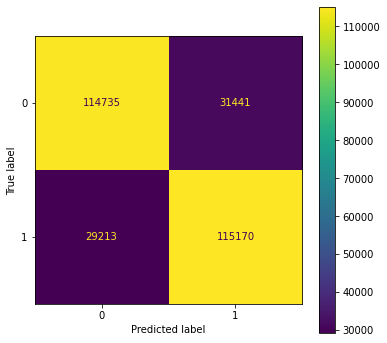

--- ROC AUC ---------------------------------------------------------------------------------------- 



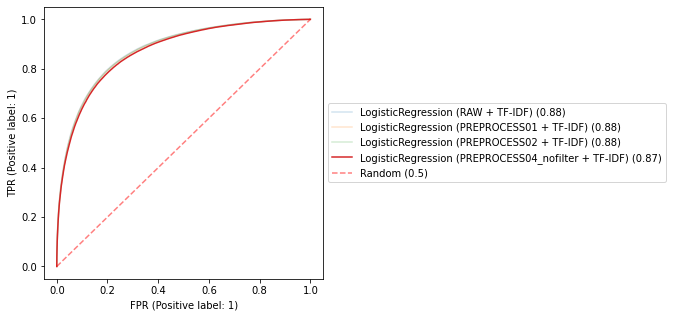

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



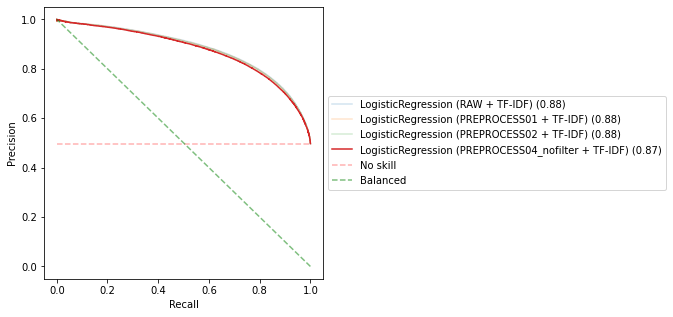

In [43]:
get_scores(model_name, **grd_log, register=True, X_ref=X_test, y_ref=y_test)

---
## Comparaison des `scores` <a class="anchor" id="PREPROCESS_scores"></a> [⇪](#menu)

>#### Les scores ci-dessous ont été obtenus avec divers pré-traitements initiaux
> mais la phase final de pré-traitement à dans tous les cas utilisé **TF-IDF** comme moyen de rendre compatible les textes avec le DummyClassifier et la LogisticRegression.

In [44]:
from classification_utils import scores_df

In [45]:
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,DummyClassifier (RAW + TF-IDF),None,"{'random_state': [0], 'strategy': ['stratified']}",0.501126,0.497479,0.498122,0.501144,0.498047,0.498196,71931,73681,72495,72452,2.180013,0.026919
1,LogisticRegression (RAW + TF-IDF),None,"[{'random_state': [0], 'max_iter': [3000], 'so...",0.878261,0.878619,0.798110,0.797955,0.792615,0.803682,116038,115815,30361,28345,1104.552671,0.031679
2,LogisticRegression (PREPROCESS01 + TF-IDF),None,"[{'random_state': [0], 'max_iter': [3000], 'so...",0.876879,0.877461,0.796771,0.796451,0.790656,0.802982,115937,115479,30697,28446,1021.306742,0.051024
3,LogisticRegression (PREPROCESS02 + TF-IDF),None,"[{'random_state': [0], 'max_iter': [3000], 'so...",0.876328,0.876399,0.796589,0.796093,0.789807,0.803488,116010,115302,30874,28373,970.868110,0.074385
4,LogisticRegression (PREPROCESS03 + TF-IDF),None,"[{'random_state': [0], 'max_iter': [3000], 'so...",0.847550,0.840666,0.772097,0.768460,0.755638,0.789290,113960,109323,36853,30423,629.433361,0.076786
5,LogisticRegression (PREPROCESS03_simple + TF-IDF),None,"[{'random_state': [0], 'max_iter': [3000], 'so...",0.848608,0.841821,0.773439,0.769782,0.756819,0.790806,114179,109488,36688,30204,645.602822,0.062691
6,LogisticRegression (PREPROCESS04 + TF-IDF),None,"[{'random_state': [0], 'max_iter': [3000], 'so...",0.841475,0.834905,0.765842,0.762231,0.749895,0.782481,112977,108496,37680,31406,612.631544,0.064539
7,LogisticRegression (PREPROCESS04_simple + TF-IDF),None,"[{'random_state': [0], 'max_iter': [3000], 'so...",0.842710,0.836222,0.767047,0.763418,0.750965,0.783832,113172,108646,37530,31211,616.912871,0.054205
8,LogisticRegression (PREPROCESS04_nofilter + TF...,None,"[{'random_state': [0], 'max_iter': [3000], 'so...",0.871692,0.872167,0.791563,0.791251,0.785548,0.797670,115170,114735,31441,29213,984.470571,0.094511


In [419]:
import FreeMobileSMS as sms
sms.send(stop=True)

# Test préliminaires

In [220]:
import time
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers

from sklearn.model_selection import train_test_split

random_seed=0

In [188]:
data_work = pd.read_csv(
    pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp_1563108.csv'), 
    usecols=['target', 'lemmas_not_filtered'],
    encoding='ISO-8859-1',
)
data_work.rename(columns={'lemmas_not_filtered':'text'}, inplace=True)
display(data_work.head(), data_work.shape)

,target,text
0,0,"$ url$ - awww , that be a bummer . you shoulda..."
1,0,be upset that he can not update his facebook b...
2,0,I dive many time for the ball . manage to save...
3,0,my whole body feel itchy and like its on fire
4,0,"no , it be not behave at all . I be mad . why ..."


(1452791, 2)

### Standardize & Tokenize

In [189]:
text_vectorization = tf.keras.layers.TextVectorization(
    output_mode='int', # int, multi_hot, count, tf_idf
    max_tokens=20000,
    ngrams=1,
    # output_sequence_length=60 # search the max size by default
)

In [190]:
text_vectorization.adapt(data_work.text.sample(100000, random_state=0))

In [191]:
print(text_vectorization.get_vocabulary()[:20], "...")

['', '[UNK]', 'i', 'be', 'to', 'the', 'a', 'not', 'my', 'and', 'it', 'you', 'have', 'do', 'for', 'in', 'go', 'of', 'get', 'that'] ...


### Encode

In [192]:
vocabulary = text_vectorization.get_vocabulary()
len(vocabulary)

20000

In [193]:
test_sentence = "I write, rewrite, and still rewrite again"

In [194]:
encoded_sentence = text_vectorization(test_sentence)
encoded_sentence

<tf.Tensor: shape=(7,), dtype=int64, numpy=array([   2,  319, 5460,    9,   77, 5460,  105])>

### Decode

In [195]:
inverse_vocab = dict(enumerate(vocabulary))

In [196]:
decoded_sentence = " ".join([inverse_vocab[int(x)] for x in encoded_sentence])
decoded_sentence

'i write rewrite and still rewrite again'

### Divisons le jeu de données en `Train` et `Test` sets

In [197]:
X_train, X_test, y_train, y_test = train_test_split(data_work['text'], data_work['target'], test_size=0.2, random_state=random_seed)

### Prepare dataset

In [198]:
X_train_ready = text_vectorization(X_train)
X_test_ready = text_vectorization(X_test)

In [199]:
X_train[:2]

317722    you too be fake .. :x ... disguise your link t...
37615                   my boss be still mad from I I guess
Name: text, dtype: object

In [200]:
X_train_ready[:2]

<tf.Tensor: shape=(2, 54), dtype=int64, numpy=
array([[  11,   48,    3, 1329,  191,    1,   46,  438,    4,    3,  180,
         458,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   8, 1218,    3,   77,  515,   60,    2,    2,  228,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])>

### Inspect train_ds or test_ds

### Train model

In [214]:
def summarize_diagnostics(history):
    
    figure = plt.figure(figsize=(8,8))
            
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='val')
    plt.legend()
    
    # save plot to file
    #filename = sys.argv[0].split('/')[-1]
    #plt.savefig(filename + '_plot.png')
    #plt.close()
    
    plt.tight_layout(pad=1.0)

In [16]:
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau

def init_callbacks(model_name):

    # Define savepoints
    filepath = pathlib.Path("models", f"{model_name}.epoch{{epoch:02d}}-accuracy{{val_accuracy:.2f}}.hdf5")

    checkpoint = ModelCheckpoint(
        monitor="val_accuracy",
        mode="max",
        filepath=filepath,
        save_best_only=True,
        save_weights_only=True,
        verbose=1,
    )

    # Define EarlyStopping conditions
    es = EarlyStopping(
        monitor='val_loss', # 'binary_accuracy'
        mode='min', # 'max'
        patience=10,  # 6 because ReduceLROnPlateau is 5 
        min_delta=0.01, 
        restore_best_weights=True, 
        verbose=1,
    )

    # Define Automatic LearningRate adjustments
    lr_reducer = ReduceLROnPlateau(
        monitor='val_loss',
        mode='min',
        factor=0.1,
        cooldown=5,
        patience=5,
        min_lr= 0.1e-5,
        verbose=1,
    )
    
    return [checkpoint, es, lr_reducer]

In [23]:
def architecture01(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    x = layers.Dense(24, activation='relu')(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model

In [202]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

In [203]:
def train_model(X_train_, X_test_, y_train_, y_test_, vocab_size_, embedding_layer_, preprocess_desc=""):
    
    print(f"Testing model with \"{preprocess_desc}\"".upper().center(100,"-"), end='\n\n')
    
    # Prepare model
    f_opti = keras.optimizers.Adam(learning_rate=0.0005)
    f_loss = keras.losses.BinaryCrossentropy(from_logits=False)
    f_metrics = ['accuracy'] # in this context 'accuracy' == keras.metrics.BinaryAccuracy()
    
    model = architecture01(f_opti, f_loss, f_metrics, embedding_layer_)
    model.summary()
    
    t0 = time.perf_counter()
    history = model.fit(
        x=X_train_, y=y_train_, 
        validation_data=(X_test_, y_test_), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"archi01_PREPROCESS_{preprocess_desc}"),
        verbose=1,
        # validation_split=0.2,
        # train_labels
    )
    train_time = time.perf_counter() - t0
    
    # Print accuracy scores
    loss, accuracy = model.evaluate(X_train_ready, y_train, verbose=False)
    print("\nTraining Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(X_test_ready, y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))
    
    return history, model, train_time

In [204]:
# Embedding simple
padding_size = X_train_ready.shape[1]
embedding_dim = 100
vocab_size = len(vocabulary)
embedding_layer = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=padding_size, trainable=True)

In [211]:
history_W2V300, model_W2V300, train_time = train_model(X_train_ready, X_test_ready, y_train, y_test, vocab_size, embedding_layer, "W2V300")

------------------------------------TESTING MODEL WITH "W2V300"-------------------------------------

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 100)         2000000   
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 24)                3096      
                                                                 
 predictions (Dense)         (None, 1)                 25        
                                                                 
Total params: 2,087,601

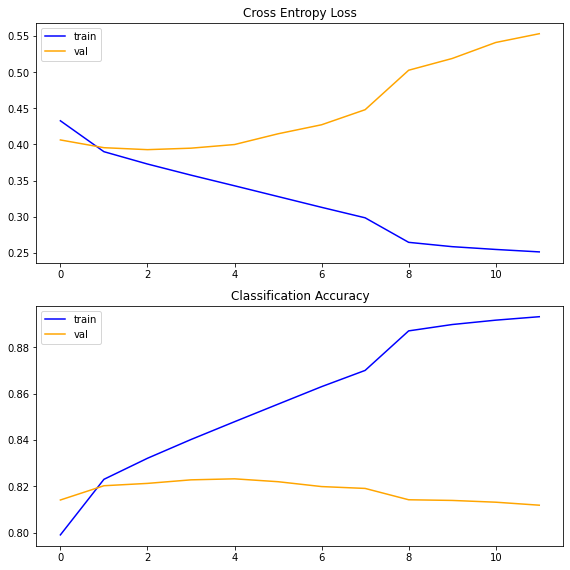

In [217]:
summarize_diagnostics(history_W2V300)

In [218]:
from classification_utils import fit_model, get_scores, init_scores

init_scores("data/scores_NN_SelectEmbeddingTESTS.csv")

### Affichons les scores du modèle

In [221]:
t0 = time.perf_counter()
y_preds_proba = model_W2V300.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0

y_preds_proba.shape
y_preds.shape

9080/9080 [==============================] - 69s 8ms/step


(290559, 1)

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- NN Archi01 (PT_W2V_300 + Lemma_nof + Tokenizer4500) --------------------------------------------

             ROC_AUC : 0.9026
                  F1 : 0.8207
            ACCURACY : 0.8203
           PRECISION : 0.8139
              RECALL : 0.8275
   AVERAGE_PRECISION : 0.9037

       TRAINING-TIME : 9087.3585
      INFERENCE-TIME : 70.9427

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.83      0.81      0.82    146176
Prediction = 1       0.81      0.83      0.82    144383

      accuracy                           0.82    290559
     macro avg    

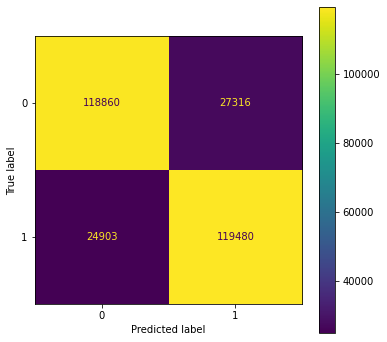

--- ROC AUC ---------------------------------------------------------------------------------------- 



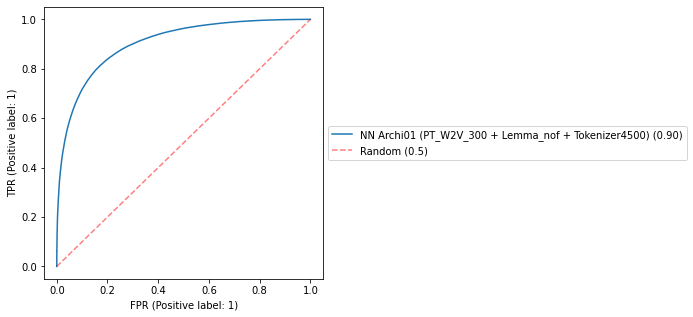

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



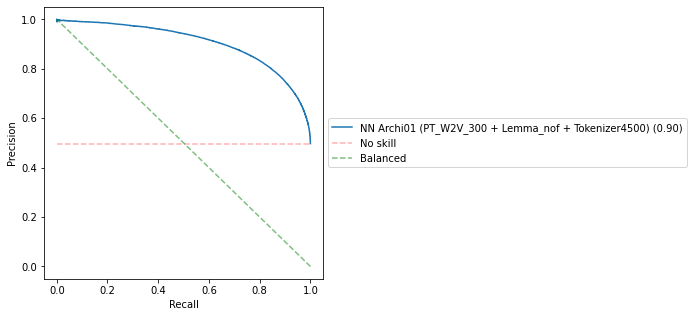

In [222]:
model_name = "NN Archi01 (PT_W2V_300 + Lemma_nof + Tokenizer4500)"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

In [240]:
# Prepare model
f_opti = keras.optimizers.Adam(learning_rate=0.0005)
f_loss = keras.losses.BinaryCrossentropy(from_logits=False)
f_metrics = ['accuracy'] # in this context 'accuracy' == keras.metrics.BinaryAccuracy()
    
TEST_model = architecture01(f_opti, f_loss, f_metrics, embedding_layer)
TEST_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 100)         2000000   
                                                                 
 bidirectional_7 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 24)                3096      
                                                                 
 predictions (Dense)         (None, 1)                 25        
                                                                 
Total params: 2,087,601
Trainable params: 2,087,601
Non-trainable params: 0
_________________________________________________

In [226]:
t0 = time.perf_counter()
y_preds_proba = TEST_model.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0

y_preds_proba.shape
y_preds.shape

9080/9080 [==============================] - 66s 7ms/step


(290559, 1)

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- TEST1 ------------------------------------------------------------------------------------------

             ROC_AUC : 0.5650
                  F1 : 0.5338
            ACCURACY : 0.5434
           PRECISION : 0.5418
              RECALL : 0.5261
   AVERAGE_PRECISION : 0.5558

       TRAINING-TIME : 9087.3585
      INFERENCE-TIME : 68.5046

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.54      0.56      0.55    146176
Prediction = 1       0.54      0.53      0.53    144383

      accuracy                           0.54    290559
     macro avg    

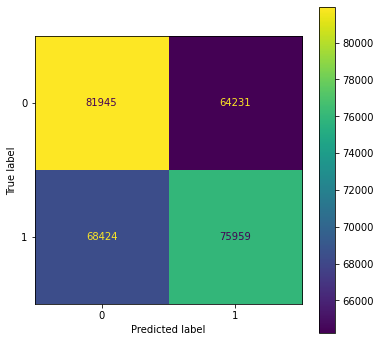

--- ROC AUC ---------------------------------------------------------------------------------------- 



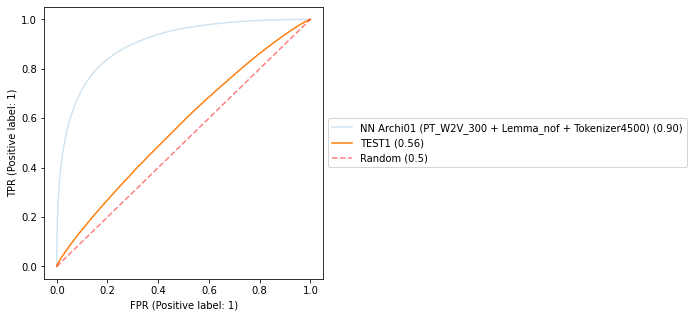

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



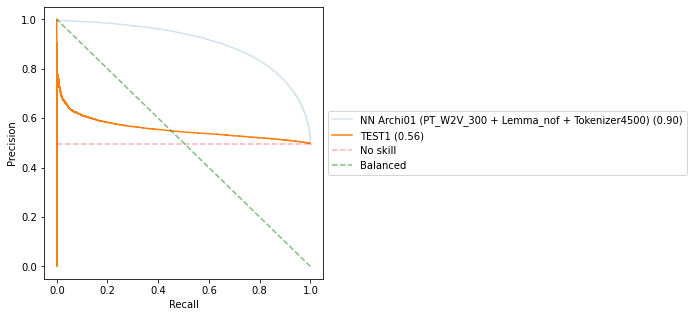

In [227]:
model_name = "TEST1"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

In [241]:
# Restore the weights
TEST_model.load_weights('models/archi01_PREPROCESS_W2V300.epoch05-accuracy0.82.hdf5')

In [242]:
t0 = time.perf_counter()
y_preds_proba = TEST_model.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0

y_preds_proba.shape
y_preds.shape

9080/9080 [==============================] - 64s 7ms/step


(290559, 1)

In [244]:
TEST_model.evaluate(X_test_ready, y_test)

9080/9080 [==============================] - 68s 7ms/step - loss: 0.3999 - accuracy: 0.8233


[0.39988774061203003, 0.8232613801956177]

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- TEST1 ------------------------------------------------------------------------------------------

             ROC_AUC : 0.9032
                  F1 : 0.8186
            ACCURACY : 0.8233
           PRECISION : 0.8354
              RECALL : 0.8025
   AVERAGE_PRECISION : 0.9034

       TRAINING-TIME : 9087.3585
      INFERENCE-TIME : 65.9699

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.81      0.84      0.83    146176
Prediction = 1       0.84      0.80      0.82    144383

      accuracy                           0.82    290559
     macro avg    

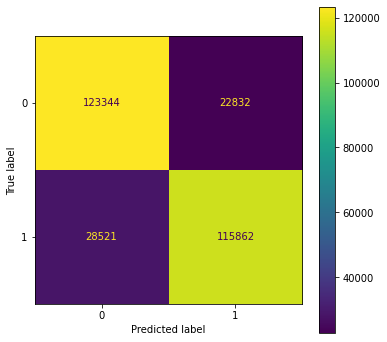

--- ROC AUC ---------------------------------------------------------------------------------------- 



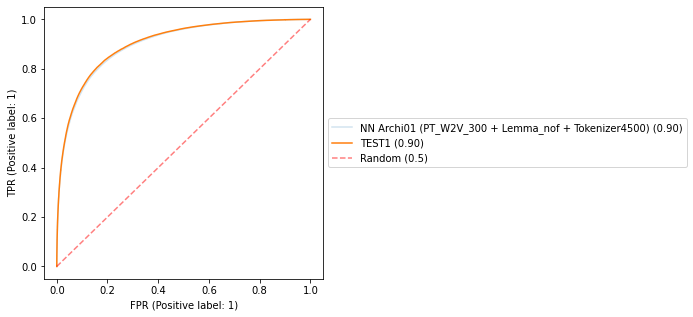

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



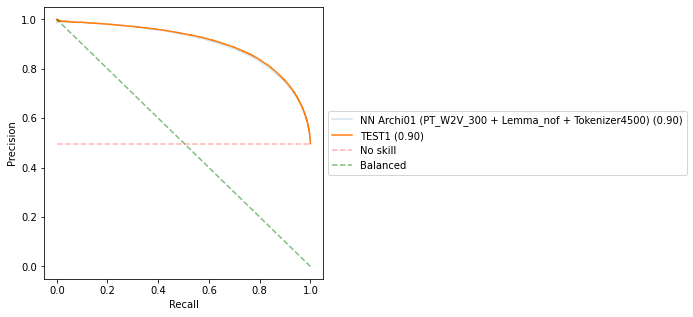

In [243]:
model_name = "TEST1"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

> **Donc en fait, si je prend le modèle tel-quel après entrainement, il n'a PAS remis le meilleur modèle trouvé !!!**

In [238]:
t0 = time.perf_counter()
y_preds_proba = model_W2V300.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0

y_preds_proba.shape
y_preds.shape

9080/9080 [==============================] - 65s 7ms/step


(290559, 1)

In [245]:
model_W2V300.evaluate(X_test_ready, y_test)

9080/9080 [==============================] - 81s 9ms/step - loss: 0.4111 - accuracy: 0.8177


[0.41106823086738586, 0.8177272081375122]

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- NN Archi01 (PT_W2V_300 + Lemma_nof + Tokenizer4500) --------------------------------------------

             ROC_AUC : 0.9001
                  F1 : 0.8195
            ACCURACY : 0.8177
           PRECISION : 0.8067
              RECALL : 0.8327
   AVERAGE_PRECISION : 0.9003

       TRAINING-TIME : 9087.3585
      INFERENCE-TIME : 66.9242

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.83      0.80      0.82    146176
Prediction = 1       0.81      0.83      0.82    144383

      accuracy                           0.82    290559
     macro avg    

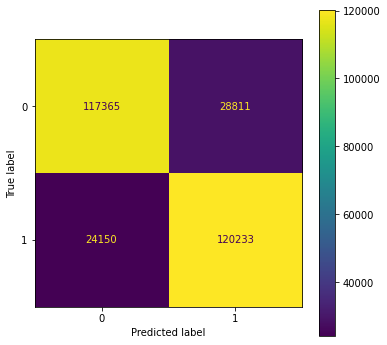

--- ROC AUC ---------------------------------------------------------------------------------------- 



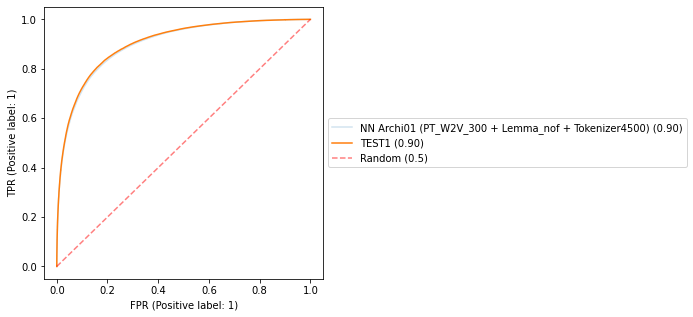

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



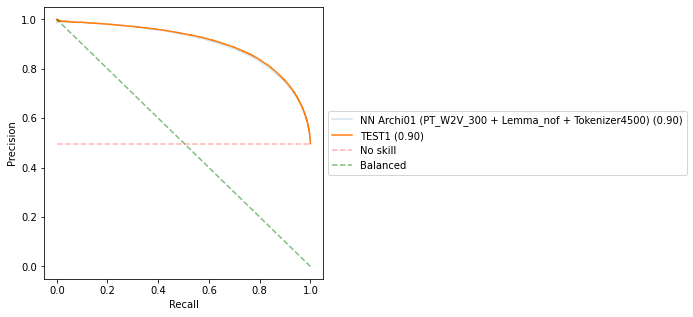

In [239]:
model_name = "NN Archi01 (PT_W2V_300 + Lemma_nof + Tokenizer4500)"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

## Packaging

In [272]:
inputs = keras.Input(shape=(1,), dtype='string')
processed_inputs = text_vectorization(inputs)
outputs = TEST_model(processed_inputs)
inference_model = keras.Model(inputs, outputs)

In [273]:
raw_text = tf.convert_to_tensor(["I like it", "I don't like it"])
inference_model(raw_text)

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.8261073 ],
       [0.16891088]], dtype=float32)>

In [278]:
# Compile before exporting BUT nit required for inference
inference_model.compile(optimizer='adam', loss='binary_crossentropy')

inference_model.save("models/TEST3")

INFO:tensorflow:Assets written to: models/TEST3/assets


INFO:tensorflow:Assets written to: models/TEST3/assets


In [279]:
XXX = keras.models.load_model("models/TEST3")

In [280]:
raw_text = tf.convert_to_tensor(["I like it", "I don't like it"])
XXX(raw_text)

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.8261073 ],
       [0.16891088]], dtype=float32)>

---
---
---
---
---